In [1]:
import os
import copy
import math
import shutil
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from functools import reduce
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#### Plot nuclei positions and velocity

In [2]:
daystring = "10"
spotstring = "01"

fpath = "YuLong_Data/day_" + daystring + "/" + spotstring + "spot.csv"
dirname = "YuLong_Day" + daystring + "_Spot" + spotstring

df = pd.read_csv(fpath)
max_frame = np.max(list(df['FRAME']))
max_xlim = np.ceil(np.max(df['POSITION_X'])) + 1
max_ylim = np.ceil(np.max(df['POSITION_Y'])) + 1
max_zlim = np.ceil(np.max(df['POSITION_Z'])) + 1
min_xlim = np.floor(np.min(df['POSITION_X'])) - 1
min_ylim = np.floor(np.min(df['POSITION_Y'])) - 1
min_zlim = np.floor(np.min(df['POSITION_Z'])) - 1
max_lim = np.max([max_xlim, max_ylim, max_zlim])
min_lim = np.min([min_xlim, min_ylim, min_zlim])

In [3]:
show_quiver = False
show_track = True
show_com_mavv = False

odirname = dirname + "_plots"
if os.path.isdir(odirname):
    shutil.rmtree(odirname)
    os.mkdir(odirname)
else:
    os.mkdir(odirname)

for tp in range(1, max_frame+1):
        
    ipath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Frame" + repr(tp) + ".npz"
    track_data = np.load(ipath)
    
    vpath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Velocity" + repr(tp) + ".npz"
    vel_data = np.load(vpath)
    
    cell_pos = track_data["positions"]
    omega = vel_data["orientation"]
    
    plt.figure(figsize=(5,4), dpi=200)
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(cell_pos[:,0], cell_pos[:,1], cell_pos[:,2], s=4, color='black')
    
    x_com = np.mean(cell_pos[:,0])
    y_com = np.mean(cell_pos[:,1])
    z_com = np.mean(cell_pos[:,2])
    
    if show_com_mavv:
        ax.quiver(x_com, y_com, z_com, omega[0], omega[1], omega[2], linewidth=1)
    
    for key in track_data.keys():
        
        if key == "positions":
            continue
        if key == "edgepairs":
            continue
        if (key == "lumen1" or key == "lumen2" or key == "lumen3" or key == "lumen4" or key == "lumen5"):
            continue
            
        cell_track = track_data[key]
        x_pos = cell_track[:,0][::-1]
        y_pos = cell_track[:,1][::-1]
        z_pos = cell_track[:,2][::-1]
        
        if show_track:
            ax.plot3D(x_pos, y_pos, z_pos, 'gray', linewidth=0.5)
        
        if show_quiver:
            try:
                cell_vel = vel_data[key]
                ax.quiver(x_pos[-1], y_pos[-1], z_pos[-1], cell_vel[0], cell_vel[1], cell_vel[2], 
                          length=2, normalize=True, linewidth=0.5, color='blue')
            except:
                continue
                
        ax.text(x_pos[-1], y_pos[-1], z_pos[-1], key, color='red', fontsize=4)
        
    # make axes
    ax_x = (min_lim, min_lim, min_lim)
    ax_y = (max_lim, max_lim, max_lim)
    ax_z = (min_lim, min_lim, min_lim)
    ax.scatter3D(min_lim, max_lim, min_lim, s=2, color="gray")
    ax_u, ax_v, ax_w = np.array([[1,0,0], [0,-1,0], [0,0,1]])
    ax.quiver(ax_x, ax_y, ax_z, ax_u, ax_v, ax_w, length=max_lim-min_lim, 
              linewidth=1.0, arrow_length_ratio=0.05, color='gray')
    
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.set_zlim([min_lim, max_lim])
    ax.grid(False)
    plt.axis('off')
        
    outfname = "Frame" + repr(tp).zfill(3) + ".png"
    outfullpath = odirname + os.sep + outfname
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.set_zlim([min_lim, max_lim])
    plt.title("Spot " + spotstring + " (Frame: " + repr(tp) + ")", fontsize=8)
    plt.savefig(outfullpath)
    plt.close()

In [4]:
! cp make_png_movie.sh YuLong_Day10_Spot01_plots/

#### Plot representative lumens

In [5]:
def signed_vol_tri(p1, p2, p3):
    v321 = p3[0] * p2[1] * p1[2]
    v231 = p2[0] * p3[1] * p1[2]
    v312 = p3[0] * p1[1] * p2[2]
    v132 = p1[0] * p3[1] * p2[2]
    v213 = p2[0] * p1[1] * p3[2]
    v123 = p1[0] * p2[1] * p3[2]
    return (1.0/6.0)*(-v321 + v231 + v312 - v132 - v213 + v123)

def area_tri(p1, p2, p3):
    a = np.linalg.norm(p1-p2)
    b = np.linalg.norm(p2-p3)
    c = np.linalg.norm(p3-p1)
    s = (a+b+c)/2
    return np.sqrt(s*(s-a)*(s-b)*(s-c))

def mesh_vol(pt_coords, tri_indices):
    num_triangles = np.shape(tri_indices)[0]
    tot_vol = 0.0
    tot_area = 0.0
    for i in range(num_triangles):
        pt_indices = tri_indices[i,:]
        p1 = pt_coords[int(pt_indices[0])-1,:]
        p2 = pt_coords[int(pt_indices[1])-1,:]
        p3 = pt_coords[int(pt_indices[2])-1,:]
        tot_vol += signed_vol_tri(p1, p2, p3)
        tot_area += area_tri(p1, p2, p3)
    return (np.abs(tot_vol), tot_area)

def interp_line(point1, point2):
    a = (point2[1] - point1[1])/(np.cosh(point2[0]) - np.cosh(point1[0]))
    b = point1[1] - a*np.cosh(point1[0])
    x = np.linspace(point1[0], point2[0], 100)
    y = a*np.cosh(x) + b
    return (x, y)

def factors(n):
    step = 2 if n%2 else 1
    return list(reduce(list.__add__, ([i, n//i] for i in range(1, int(math.sqrt(n))+1, step) 
                                     if n % i == 0)))

In [6]:
lumen_associated_tracks = dict()

for tp in range(1, max_frame+1):
        
    ipath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Frame" + repr(tp) + ".npz"
    track_data = np.load(ipath)
    
    cell_pos = track_data["positions"]
    lumens_exist = [True, True, True, True, True]
    
    for lumen_idx in range(1, 6):
        
        try:

            lumen_pts = track_data["lumen" + repr(lumen_idx)]
            cellids = [int(idx-1) for idx in np.unique(lumen_pts)]
            for cididx in cellids:
                track_id = int(cell_pos[cididx][3])
                if track_id in lumen_associated_tracks.keys():
                    lumen_associated_tracks[track_id][lumen_idx-1] += 1
                else:
                    lumen_associated_tracks[track_id] = [0, 0, 0, 0, 0]
                    lumen_associated_tracks[track_id][lumen_idx-1] += 1
                    
        except:
            
            lumens_exist[lumen_idx-1] = False

association_times = []
associated_track_ids = []
associated_lumens = []

lumen_histograms = [[], [], [], [], []]

for track_id in lumen_associated_tracks.keys():
    lumen_associated_tracks[track_id] = lumen_associated_tracks[track_id]/max_frame
    for lumen_idx in range(1, 6): 
        lumen_histograms[lumen_idx-1].append(100 * lumen_associated_tracks[track_id][lumen_idx-1])
    argmax_idx = np.argmax(lumen_associated_tracks[track_id])
    assoc_time = np.round(100*lumen_associated_tracks[track_id][argmax_idx], decimals=2)
    assoc_lumen = argmax_idx+1
    # print("TrackID " + repr(track_id) + ": Lumen " + repr(assoc_lumen) + " (" + repr(assoc_time) + "%)")
    association_times.append(assoc_time)
    associated_track_ids.append(track_id)
    associated_lumens.append(assoc_lumen)

blue_lumen_seeds = []
red_lumen_seeds = []
green_lumen_seeds = []

num_associated_cells = 10

sorted_idx = np.flip(np.argsort(association_times))
for itr in range(len(association_times)):
    assoc_lumen = associated_lumens[sorted_idx[itr]]
    assoc_track = associated_track_ids[sorted_idx[itr]]
    assoc_time = association_times[sorted_idx[itr]]
    if assoc_lumen == 1:
        if len(blue_lumen_seeds) < num_associated_cells:
            blue_lumen_seeds.append(assoc_track)
    elif assoc_lumen == 2:
        if len(red_lumen_seeds) < num_associated_cells:
            red_lumen_seeds.append(assoc_track)
    elif assoc_lumen == 3:
        if len(green_lumen_seeds) < num_associated_cells:
            green_lumen_seeds.append(assoc_track)
    # print("Track ID " + repr(assoc_track) + ": Lumen " + repr(assoc_lumen) + " (" + repr(assoc_time) + "%)")
    
print("Cells mostly associated with blue lumen: " + repr(blue_lumen_seeds))
print("Cells mostly associated with red lumen: " + repr(red_lumen_seeds))
print("Cells mostly associated with green lumen: " + repr(green_lumen_seeds))

Cells mostly associated with blue lumen: [65, 62, 51, 66, 139, 55, 52, 57, 42, 88]
Cells mostly associated with red lumen: [38, 27, 17, 34, 136, 21, 25, 30, 28, 24]
Cells mostly associated with green lumen: [2, 128, 119, 9, 11, 130, 132, 122, 10, 8]


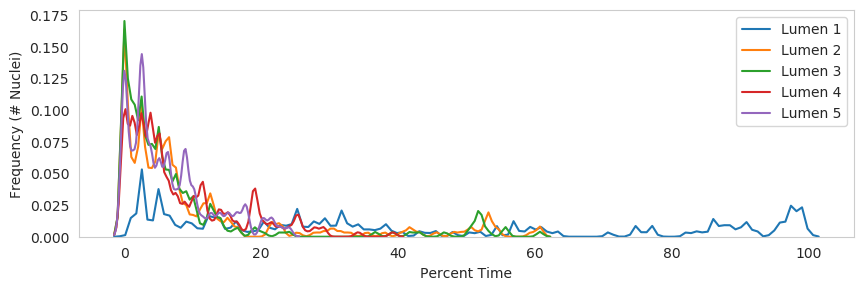

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,3), dpi=100)
for lumen_idx in range(1, 6):
    sns.kdeplot(lumen_histograms[lumen_idx-1], bw=0.5, label='Lumen ' + repr(lumen_idx))
plt.grid(False)
plt.xlabel("Percent Time")
plt.ylabel("Frequency (# Nuclei)");

In [ ]:
dirname = "YuLong_Day" + daystring + "_Spot" + spotstring
odirname = dirname + "_lumen"

if os.path.isdir(odirname):
    shutil.rmtree(odirname)
    os.mkdir(odirname)
else:
    os.mkdir(odirname)
    
plot_sphere_fit = True
lumen_coloring_order = ["Blue", "Red", "Green"]
colored_lumens_cids = [dict(), dict(), dict()]

for tp in range(1, max_frame+1):
        
    ipath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Frame" + repr(tp) + ".npz"
    track_data = np.load(ipath)
    
    cell_pos = track_data["positions"][:,:3]
    
    lumens_exist = [True, True, True, True, True]
    lumen_seed_count = [0, 0, 0, 0, 0]
    lumen_color_vote = [None, None, None, None, None]
    lumens_poly3d_data = []
    lumens_spherefit_data = []
    lumens_cids = []
    lumens_stats = []
    fc_list = ["blue", "red", "green"]
    ec_list = ["darkblue", "maroon", "darkgreen"]
    
    for lumen_idx in range(1, 6):
        
        try:

            lumen_pts = track_data["lumen" + repr(lumen_idx)]

            mesh_size = mesh_vol(cell_pos, np.transpose(lumen_pts))

            num_triangles = np.shape(lumen_pts)[1]
            vertices = np.unique(lumen_pts)
            lumen_COM_coords = [0, 0, 0]
            tri_data = np.zeros((num_triangles, 9))

            for tri in range(num_triangles):

                idx1 = int(lumen_pts[0, tri])-1
                idx2 = int(lumen_pts[1, tri])-1
                idx3 = int(lumen_pts[2, tri])-1

                coords = []
                coords.extend(cell_pos[idx1])
                coords.extend(cell_pos[idx2])
                coords.extend(cell_pos[idx3])
                tri_data[tri,:] = coords
            
            for vert_idx in vertices:
                lumen_COM_coords += cell_pos[int(vert_idx)-1]
            
            lumen_COM_coords /= len(vertices)
            sphere_radius = math.inf
            nearest_nucleus_pos = []
            
            for vert_idx in vertices:
                
                cell_coords = cell_pos[int(vert_idx)-1]
                rel_pos_vec = cell_coords - lumen_COM_coords
                rel_pos_dist = np.sqrt(np.sum(np.square(rel_pos_vec)))
                
                if rel_pos_dist < sphere_radius:
                    sphere_radius = rel_pos_dist
                    nearest_nucleus_pos = cell_coords
                
            lumens_spherefit_data.append((lumen_COM_coords, sphere_radius, nearest_nucleus_pos))
                
            poly3d = [[tri_data[i, j*3:j*3+3] for j in range(3)] for i in range(num_triangles)]
            lumens_poly3d_data.append(poly3d)
            lumens_stats.append(mesh_size)
            
            cellids = [int(idx-1) for idx in np.unique(lumen_pts)]
            lumens_cids.append(cellids)
            num_blue = 0
            num_red = 0
            num_green = 0
            for cellid in cellids:
                if cellid in blue_lumen_seeds:
                    num_blue += 1
                if cellid in red_lumen_seeds:
                    num_red += 1
                if cellid in green_lumen_seeds:
                    num_green += 1
            seed_count = 0
            if num_blue == 0 and num_red == 0 and num_green == 0:
                color_idx = None
            else:
                counts = [num_blue, num_red, num_green]
                color_idx = np.argmax(counts)
                seed_count = counts[color_idx] 
            lumen_color_vote[lumen_idx-1] = color_idx
            lumen_seed_count[lumen_idx-1] = seed_count

        except:
            
            lumens_exist[lumen_idx-1] = False
    
    fig = plt.figure(figsize=(5,4), dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    
    # make axes
    ax_x = (min_lim, min_lim, min_lim)
    ax_y = (max_lim, max_lim, max_lim)
    ax_z = (min_lim, min_lim, min_lim)
    ax.scatter3D(min_lim, max_lim, min_lim, s=2, color="gray")
    ax_u, ax_v, ax_w = np.array([[1,0,0], [0,-1,0], [0,0,1]])
    ax.quiver(ax_x, ax_y, ax_z, ax_u, ax_v, ax_w, length=max_lim-min_lim, 
              linewidth=1.0, arrow_length_ratio=0.05, color='gray')
    
    # plot nuclei
    ax.scatter3D(cell_pos[:,0], cell_pos[:,1], cell_pos[:,2], s=4, color='black', zorder=1)
    
    print("Frame " + repr(tp))
    print(lumen_seed_count)
    print(lumen_color_vote)
    
    title_string = "Spot " + spotstring + " (Frame: " + repr(tp) + ")"
    # plot blue, red and green lumens
    for l_clr in [0, 1, 2]:
        
        max_seed_val = 0
        max_seed_size = 0
        max_seed_idx = None
        
        for lumen_idx in range(len(lumen_color_vote)):
            if lumen_color_vote[lumen_idx] == l_clr:
                if lumen_seed_count[lumen_idx] > max_seed_val:
                    max_seed_val = lumen_seed_count[lumen_idx]
                    max_seed_size = lumens_stats[lumen_idx][0]
                    max_seed_idx = lumen_idx
                elif lumen_seed_count[lumen_idx] == max_seed_val:
                    if lumens_stats[lumen_idx][0] > max_seed_size:
                        max_seed_val = lumen_seed_count[lumen_idx]
                        max_seed_size = lumens_stats[lumen_idx][0]
                        max_seed_idx = lumen_idx
                        
        if max_seed_idx != None:
            
            if lumen_seed_count[max_seed_idx] > 5:
                
                clr_idx = lumen_color_vote[max_seed_idx]
                
                if plot_sphere_fit:
                    
                    sph_phi = np.linspace(0, np.pi, 50)
                    sph_theta = np.linspace(0, 2*np.pi, 50)
                    sph_phi, sph_theta = np.meshgrid(sph_phi, sph_theta)
                    
                    sph_r = lumens_spherefit_data[max_seed_idx][1]
                    sph_COM_x = lumens_spherefit_data[max_seed_idx][0][0]
                    sph_COM_y = lumens_spherefit_data[max_seed_idx][0][1]
                    sph_COM_z = lumens_spherefit_data[max_seed_idx][0][2]
                    nearest_nucleus_pos = lumens_spherefit_data[max_seed_idx][2]
                    
                    sph_x = sph_r * np.sin(sph_phi) * np.cos(sph_theta) + sph_COM_x
                    sph_y = sph_r * np.sin(sph_phi) * np.sin(sph_theta) + sph_COM_y
                    sph_z = sph_r * np.cos(sph_phi) + sph_COM_z
                    
                    face_clrs = np.empty(sph_x.shape, dtype=str)
                    for yidx in range(sph_x.shape[1]):
                        for xidx in range(sph_x.shape[0]):
                            face_clrs[xidx, yidx] = fc_list[clr_idx]
                    
                    ax.plot_surface(sph_x, sph_y, sph_z, rstride=1, cstride=1, 
                                    facecolors=face_clrs, edgecolors=None, alpha=0.05)
                    
                    ax.scatter3D(nearest_nucleus_pos[0], nearest_nucleus_pos[1], nearest_nucleus_pos[2], 
                                 s=4, color='r', depthshade=False, linewidth=1.5, zorder=2)
                
                else:
                    
                    ax.add_collection3d(Poly3DCollection(lumens_poly3d_data[max_seed_idx], 
                                                         facecolors=fc_list[clr_idx], 
                                                         edgecolors=ec_list[clr_idx], 
                                                         linewidths=0.3, linestyles=':', alpha=0.1))
                    
                lumen_vol = int(np.around(lumens_stats[max_seed_idx][0], decimals=0))
                lumen_sa = int(np.around(lumens_stats[max_seed_idx][1], decimals=0))
                title_string += "\n[" + lumen_coloring_order[l_clr]
                title_string += " Lumen] Vol: " + repr(lumen_vol) + " $\mu m^3$"
                title_string += ", SArea: " + repr(lumen_sa) + " $\mu m^2$"
                colored_lumens_cids[l_clr][tp] = lumens_cids[max_seed_idx]
                print(lumen_coloring_order[l_clr] + " chosen: " + repr(max_seed_idx))
                
            else:
                
                title_string += "\n[" + lumen_coloring_order[l_clr] + "] Lumen Vol: N/A, SArea: N/A"
                colored_lumens_cids[l_clr][tp] = []
                print(lumen_coloring_order[l_clr] + " chosen: None")
        
        else:
            
            title_string += "\n[" + lumen_coloring_order[l_clr] + "] Lumen Vol: N/A, SArea: N/A"
            colored_lumens_cids[l_clr][tp] = []
            print(lumen_coloring_order[l_clr] + " chosen: None")
            
    print("")
    
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.set_zlim([min_lim, max_lim])
    ax.grid(False)
    plt.axis('off')
    
    outfname = "Frame" + repr(tp).zfill(3) + ".png"
    outfullpath = odirname + os.sep + outfname
    
    plt.title(title_string, fontsize=5)
    plt.savefig(outfullpath)
    plt.close()

In [9]:
! cp make_png_movie.sh YuLong_Day10_Spot01_lumen/

#### Track lumen associated cells

Plotting lumen association every 6 frames



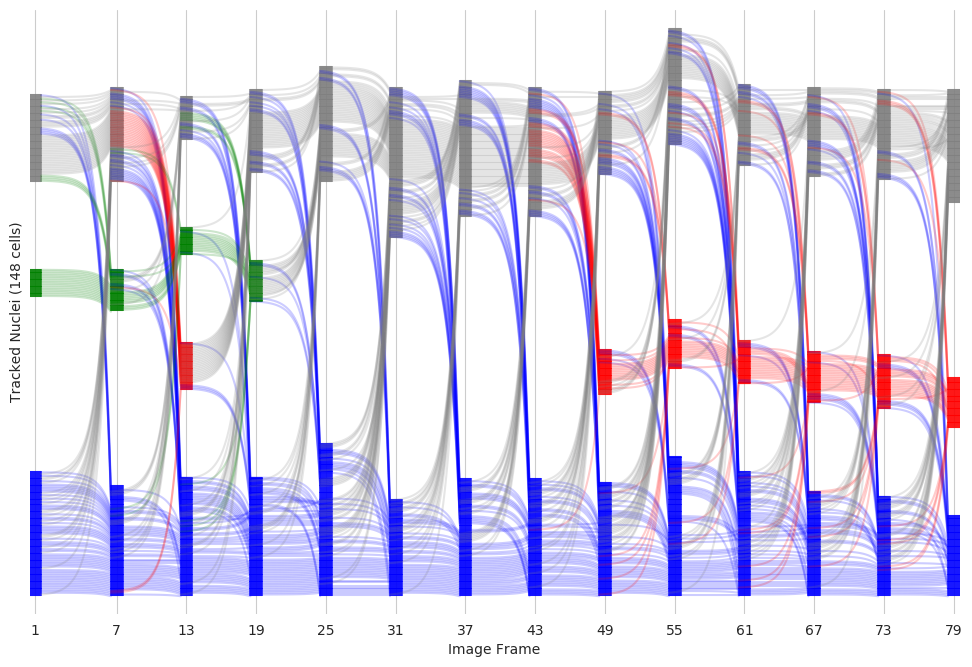

In [10]:
frame_step_size = None
step_sizes = [int(fc) for fc in factors(max_frame-1)]
for fc in sorted(step_sizes):
    if fc > 10:
        break
    frame_step_size = fc

print("Plotting lumen association every " + repr(frame_step_size) + " frames\n")

plt.figure(figsize=(12,8), dpi=100, frameon=False)

max_num_cells = 0
max_plot_y = 0

prev_line_segments = None
prev_num_cells = None

xtick_vals = []
for tp in range(1, max_frame+1, frame_step_size):
        
    ipath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Frame" + repr(tp) + ".npz"
    track_data = np.load(ipath)
    
    cell_pos = track_data["positions"][:,:3]
    lumen1_cids = colored_lumens_cids[0][tp]
    lumen2_cids = colored_lumens_cids[1][tp]
    lumen3_cids = colored_lumens_cids[2][tp]
    
    num_cells = np.shape(cell_pos)[0]
    if num_cells > max_num_cells:
        max_num_cells = num_cells
        
    line_segments = dict()
    
    for cid in range(num_cells):
        
        in_lumen1 = (cid) in lumen1_cids
        in_lumen2 = (cid) in lumen2_cids
        in_lumen3 = (cid) in lumen3_cids
        
        if in_lumen3:
            line_segments[cid+1] = [[tp-frame_step_size, tp], 'g-', None, 0.2]
        elif in_lumen2:
            line_segments[cid+1] = [[tp-frame_step_size, tp], 'r-', None, 0.2]
        elif in_lumen1:
            line_segments[cid+1] = [[tp-frame_step_size, tp], 'b-', None, 0.2]
        else:
            line_segments[cid+1] = [[tp-frame_step_size, tp], 'gray', None, 0.2]
       
    plot_y = 0
    
    if prev_line_segments == None:
        for lclr in ['b-', 'r-', 'g-', 'gray']:
            for cid in range(num_cells):
                if line_segments[cid+1][1] == lclr:
                    plot_y += 1
                    line_segments[cid+1][2] = plot_y
                    plt.plot(line_segments[cid+1][0], [plot_y, plot_y], lclr, alpha=0.9)
            plot_y += 50
    else:
        for lclr in ['b-', 'r-', 'g-', 'gray']:
            for prevclr in ['b-', 'r-', 'g-', 'gray']:
                for cid in range(num_cells):
                    if line_segments[cid+1][1] == lclr:
                        if (cid+1) <= prev_num_cells:
                            if prev_line_segments[cid+1][1] == prevclr:
                                pt_start = [line_segments[cid+1][0][0], prev_line_segments[cid+1][2]]
                                pt_end = [line_segments[cid+1][0][1], plot_y]
                                xd, yd = interp_line(pt_start, pt_end)
                                plot_y += 1
                                line_segments[cid+1][2] = plot_y
                                plt.plot(xd, yd, lclr, alpha=line_segments[cid+1][3])
                                plt.plot([tp, tp+1], [plot_y, plot_y], lclr, alpha=0.9)
                        else:
                            plot_y += 1
                            line_segments[cid+1][2] = plot_y
                            plt.plot([tp, tp+1], [plot_y, plot_y], lclr, alpha=0.9)
            plot_y += 50
    
    prev_line_segments = copy.deepcopy(line_segments)
    prev_num_cells = num_cells
    if plot_y > max_plot_y:
        max_plot_y = plot_y
        
    xtick_vals.append(tp)
    
xtick_vals_label = [str(xtv) for xtv in xtick_vals]
xtick_vals = [xtv + 0.5 for xtv in xtick_vals]
xtick_vals[0] = xtick_vals[0] - 1

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.yticks([])
plt.ylabel("Tracked Nuclei (" + repr(max_num_cells) + " cells)")
plt.xlabel("Image Frame")
plt.ylim([-10, max_plot_y-39])
plt.xlim([0, max_frame+1])
plt.xticks(xtick_vals, xtick_vals_label)
plt.show()

#### Plot connectivity graph

In [11]:
dirname = "YuLong_Day" + daystring + "_Spot" + spotstring
odirname = dirname + "_graph"

if os.path.isdir(odirname):
    shutil.rmtree(odirname)
    os.mkdir(odirname)
else:
    os.mkdir(odirname)

for tp in range(1, max_frame+1):
        
    ipath = dirname + os.sep + "YuLong_Day" + daystring + "_Spot" + spotstring + "_Frame" + repr(tp) + ".npz"
    track_data = np.load(ipath)
    
    cell_pos = track_data["positions"]
    num_cells = np.shape(cell_pos)[0]
    
    fig = plt.figure(figsize=(5,4), dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    title_string = "Spot " + spotstring + " (Frame: " + repr(tp) + ")"
    
    # make axes
    ax_x = (min_lim, min_lim, min_lim)
    ax_y = (max_lim, max_lim, max_lim)
    ax_z = (min_lim, min_lim, min_lim)
    ax.scatter3D(min_lim, max_lim, min_lim, s=2, color="gray")
    ax_u, ax_v, ax_w = np.array([[1,0,0], [0,-1,0], [0,0,1]])
    ax.quiver(ax_x, ax_y, ax_z, ax_u, ax_v, ax_w, length=max_lim-min_lim, 
              linewidth=1.0, arrow_length_ratio=0.05, color='gray')
    
    vert_deg = dict()
    
    try:
        
        edges = track_data["edgepairs"]
        
        num_edges = np.shape(edges)[0]
        
        edge_lw = 0.5
        
        for e_idx in range(num_edges):
            
            vert1_idx = int(edges[e_idx][0])-1
            vert2_idx = int(edges[e_idx][1])-1
            
            pt1 = cell_pos[vert1_idx]
            pt2 = cell_pos[vert2_idx]
            
            if vert1_idx in vert_deg.keys():
                vert_deg[vert1_idx] += 1
            else:
                vert_deg[vert1_idx] = 1
            if vert2_idx in vert_deg.keys():
                vert_deg[vert2_idx] += 1
            else:
                vert_deg[vert2_idx] = 1
            
            ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], [pt1[2], pt2[2]], 'b', linewidth=edge_lw, alpha=0.5)
            
            if edge_lw < 2.5:
                edge_lw += 0.01
            
    except:
        
        continue
        
    vert_size = [vert_deg[idx] for idx in range(num_cells)]
        
    ax.scatter3D(cell_pos[:,0], cell_pos[:,1], cell_pos[:,2], s=vert_size, color='black')
        
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.set_zlim([min_lim, max_lim])
    ax.grid(False)
    plt.axis('off')
    
    outfname = "Frame" + repr(tp).zfill(3) + ".png"
    outfullpath = odirname + os.sep + outfname
    
    plt.title(title_string, fontsize=5)
    plt.savefig(outfullpath)
    plt.close()

In [12]:
! cp make_png_movie.sh YuLong_Day10_Spot01_graph/

#### Plot overlapping spheres

In [13]:
dirname = "YuLong_Day" + daystring + "_Spot" + spotstring
odirname = dirname + "_OS"

if os.path.isdir(odirname):
    shutil.rmtree(odirname)
    os.mkdir(odirname)
else:
    os.mkdir(odirname)

for tp in range(1, max_frame+1):
    
    df_subset = df[df['FRAME'] == tp]
    pos_x = list(df_subset['POSITION_X'])
    pos_y = list(df_subset['POSITION_Y'])
    pos_z = list(df_subset['POSITION_Z'])
    diameter = list(df_subset['ESTIMATED_DIAMETER'])
    num_cells = np.shape(pos_x)[0]
    
    fig = plt.figure(figsize=(5,4), dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    title_string = "Spot " + spotstring + " (Frame: " + repr(tp) + ")\n\n"
    
    # make axes
    ax_x = (min_lim, min_lim, min_lim)
    ax_y = (max_lim, max_lim, max_lim)
    ax_z = (min_lim, min_lim, min_lim)
    
    ax.text(min_lim-10, min_lim-10, min_lim-10, "Y", color="gray", size='small')
    ax.text(max_lim, max_lim+10, min_lim-10, "X", color="gray", size='small')
    ax.text(min_lim-10, max_lim, max_lim+10, "Z", color="gray", size='small')
    
    ax.scatter3D(min_lim, max_lim, min_lim, s=2, color="gray")
    ax_u, ax_v, ax_w = np.array([[1,0,0], [0,-1,0], [0,0,1]])
    ax.quiver(ax_x, ax_y, ax_z, ax_u, ax_v, ax_w, length=max_lim-min_lim, 
              linewidth=1.0, arrow_length_ratio=0.05, color='gray')
    
    ax.scatter3D(pos_x, pos_y, pos_z, s=2, color='r', alpha=0.2, zorder=2)
    
    for j in range(num_cells):
        
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        sph_x = 0.5*diameter[j]*np.cos(u)*np.sin(v) + pos_x[j]
        sph_y = 0.5*diameter[j]*np.sin(u)*np.sin(v) + pos_y[j]
        sph_z = 0.5*diameter[j]*np.cos(v) + pos_z[j]
        
        ax.plot_surface(sph_x, sph_y, sph_z, rstride=1, cstride=1, 
                        color='b', alpha=0.35, linewidth=0, zorder=1)
    
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.set_zlim([min_lim, max_lim])
    
    ax.grid(False)
    plt.axis('off')
    
    outfname = "Frame" + repr(tp).zfill(3) + ".png"
    outfullpath = odirname + os.sep + outfname
    
    plt.title(title_string, fontsize=5)
    plt.savefig(outfullpath)
    plt.close()

In [14]:
! cp make_png_movie.sh YuLong_Day10_Spot01_OS/